<a href="https://colab.research.google.com/github/RaswanthMurugan20/ML4SCI/blob/main/Quantum_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Task III - c)**

In [ ]:
!pip install -q tensorflow-quantum
!pip install cirq
!wget https://github.com/ML4SCI/ML4SCI_GSoC/raw/main/QMLHEP/qcnn/electron-photon.npz

--2022-04-19 05:23:50--  https://github.com/ML4SCI/ML4SCI_GSoC/raw/main/QMLHEP/qcnn/electron-photon.npz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ML4SCI/ML4SCI_GSoC/main/QMLHEP/qcnn/electron-photon.npz [following]
--2022-04-19 05:23:50--  https://raw.githubusercontent.com/ML4SCI/ML4SCI_GSoC/main/QMLHEP/qcnn/electron-photon.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 821002 (802K) [application/octet-stream]
Saving to: ‘electron-photon.npz.1’

electron-photon.npz 100%[===================>] 801.76K  3.36MB/s    in 0.2s    

2022-04-19 05:23:50 (3.36 MB/s) - ‘electron-photon.npz.1’ sav

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

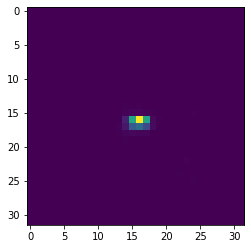

In [ ]:
data = np.load("/content/electron-photon.npz")
x_train, y_train, x_test, y_test =  data["x_train"], data["y_train"], data["x_test"], data["y_test"]
scale_factor = max(np.max(x_train), np.max(x_test))
x_train = x_train / scale_factor
x_test = x_test / scale_factor
plt.imshow(x_train[0])

In [ ]:
Q_size = (4,4)
x_train_downscale = tf.image.resize(x_train.reshape((100, 32, 32, 1)), Q_size).numpy()
x_test_downscale = tf.image.resize(x_test.reshape((100, 32, 32, 1)), Q_size).numpy()

In [ ]:
THRESHOLD = 0.5
x_train_bin = np.array(x_train_downscale > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_downscale > THRESHOLD, dtype=np.float32)

In [ ]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(Q_size[0], Q_size[1])
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit

In [ ]:
x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [ ]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

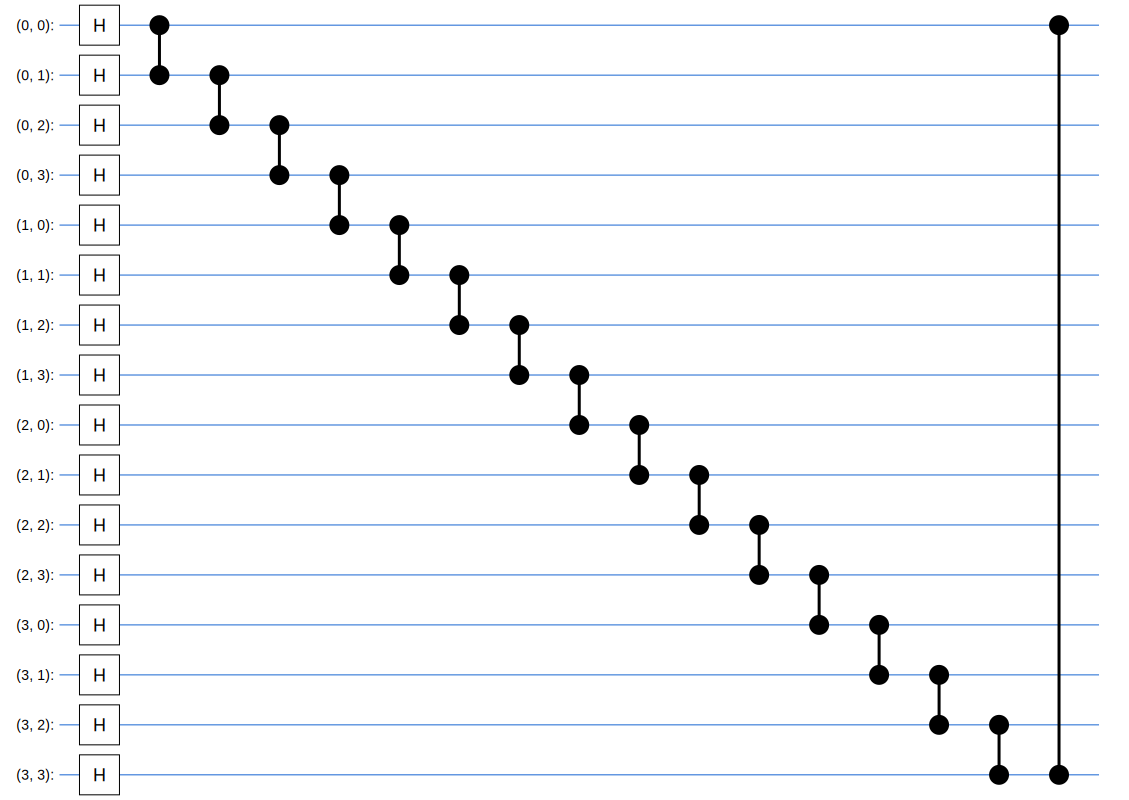

In [ ]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(4, 4)))

In [ ]:
# change data target to 1 or -1 
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

print(y_train_hinge.shape, y_test_hinge.shape)

(100,) (100,)


In [ ]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])
    

    
def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

In [ ]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit
  
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

In [ ]:
qubits = cirq.GridQubit.rect(4, 4)
readout = cirq.GridQubit(1,2)
circuit = cirq.Circuit()


symbols = sympy.symbols('qconv0:84')
circuit += quantum_conv_circuit(qubits , symbols[0:15]) # range symbols always 16
circuit += quantum_pool_circuit(qubits[:8], qubits[8:], symbols[15:21])


readout_qnn = cirq.GridQubit(1, 3)
data_qubits_qnn = cirq.GridQubit.rect(4, 4)[8:]

builder = CircuitLayerBuilder( data_qubits = data_qubits_qnn, readout=readout_qnn)

# Then add layers (experiment by adding more).
builder.add_layer(circuit, cirq.XX, "xx1")
builder.add_layer(circuit, cirq.ZZ, "zz1")
builder.add_layer(circuit, cirq.XX, "xx1")
builder.add_layer(circuit, cirq.ZZ, "zz1")

model_readout = circuit.append(cirq.H(cirq.GridQubit(1, 3)))

SVGCircuit(circuit)


readout_operators = cirq.Z(qubits[-1])

excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(qubits))

quantum_model = tfq.layers.PQC(circuit,
                               readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

In [ ]:
EPOCH = 11
BATCH_SIZE = 32

def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)
    return tf.reduce_mean(result)

In [ ]:
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
                   loss=tf.keras.losses.Hinge(),
                   metrics=[hinge_accuracy])

history = qcnn_model.fit(x=x_train_tfcirc,
                         y=y_train_hinge,
                         batch_size=20,
                         epochs=EPOCH,
                         verbose=1,
                         validation_data=(x_test_tfcirc , y_test_hinge))

Epoch 1/11
5/5 [==============================] - 40s 9s/step - loss: 0.9985 - hinge_accuracy: 0.5600 - val_loss: 1.0063 - val_hinge_accuracy: 0.4600
Epoch 2/11
5/5 [==============================] - 39s 8s/step - loss: 0.9627 - hinge_accuracy: 0.5600 - val_loss: 1.0652 - val_hinge_accuracy: 0.4600
Epoch 3/11
5/5 [==============================] - 36s 7s/step - loss: 0.9238 - hinge_accuracy: 0.5600 - val_loss: 1.0676 - val_hinge_accuracy: 0.4600
Epoch 4/11
5/5 [==============================] - 35s 7s/step - loss: 0.9396 - hinge_accuracy: 0.5600 - val_loss: 1.0650 - val_hinge_accuracy: 0.4600
Epoch 5/11
5/5 [==============================] - 36s 7s/step - loss: 0.8960 - hinge_accuracy: 0.5600 - val_loss: 1.0667 - val_hinge_accuracy: 0.4600
Epoch 6/11
5/5 [==============================] - 35s 7s/step - loss: 0.8991 - hinge_accuracy: 0.5600 - val_loss: 1.0640 - val_hinge_accuracy: 0.4600
Epoch 7/11
5/5 [==============================] - 35s 7s/step - loss: 0.9338 - hinge_accuracy: 0.560

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/